In [23]:
using Plots

## Implementación eficiente del método de Euler mejorado

Queremos simular numéricamente la evolución de sistemas modelados por 
ecuaciones diferenciales ordinarias (EDOs) de dimensión $d\geq 1$ de la forma

<a id='Edo-Compacta'></a>
\begin{equation*}
\frac{d}{dt} u = f(t,u,p). \hspace{10em} \tag{1}
\end{equation*}

donde $u =(u^1,\ldots,u^d) \in \mathbb{R}^d$ es el _vector de estado_ del sistema, y $p \in \mathbb{R}^m$ es un vector de parámetros constantes del sistema.

Sabemos que, fijado el vector $p$ de parámetros constantes, 
dados $t_0 \in \mathbb{R}$ y $u_0 =(u^1_0,\ldots,u^d_0) \in \mathbb{R}^d$, existe una única solución $u(t)$ de [(1)](#Edo-Compacta) que satisfaga la condición inicial

<a id='Cond-Ini'></a>
\begin{equation*}
  u(t_0)=u_0. \hspace{12em} \tag{2}
\end{equation*}

En la práctica, nos interesará calcular de forma aproximada la solución $u(t)$ para un cierto intervalo temporal $t \in [t_0,T]$.

Para definir un problema de valor inicial, haremos uso del la siguiente estructura (tipo compuesto) de Julia.

In [24]:
struct ProblemaEDOs{ftype,fltype}
    f::ftype
    u0::Vector{fltype}
    tspan::Tuple{fltype,fltype}
    p::Vector{fltype}
end

El campo f no necesitan explicación adicional. 
El campo tspan representa el intervalo temporal $[t_0,T]$ guardado como una tupla de dos componentes, es decir, el par ordenado $(t_0,T)$. Las componentes de los arrays guardados en los campos u0 y p, así como los de tspan, deben ser de un tipo común de datos fltype. En nuestros cálculos, habitualmente serán de tipo Float64, y cuando nos haga falta más precisión, serán de tipo BigFloat.



 La solución $u(t)$ del problema de valor inicial (1)--(2)) se aproximará para una discretización del tiempo obtenida de dividir el intervalo temporal $[t_0,T]$ en $n$ partes iguales. Es decir,  se tomará los valores discretos del tiempo $t_0,t_1,t_2,\ldots,t_{n-1},t_n=T$, donde $t_k=t_{0}+k (T-t_0)/n$, y se calcularán las aproximaciones 
$u_k =(u^1_k,\ldots,u^d_k) \approx u(t_k)$ para $k=0,1,\ldots,n$. Representaremos dicha solución aproximada discreta como una instancia del siguiente tipo compuesto de Julia.

In [25]:
struct SolucionProblemaEDOs{ftype,fltype}
    t::Vector{fltype}
    u::Vector{Vector{fltype}}
    prob::ProblemaEDOs{ftype,fltype}
end

Si sol es una instancia del tipo compuesto SolucionProblemaEDOs, en sol.u[1] tendremos $u_0$, $u_1$ en sol.u[2], $u_2$ en sol.u[3], etc. En cambio, para $j=1,\ldots,n$ en sol.t[j] tendremos $t_{j-1}$. Finalmente, en sol.prob se tendrá el problema de valor inicial el cual es solución sol.

Así, una vez que se hayan calculado las aproximaciones $u_j \approx u(t_j)$ correspondiente al problema prob::ProblemaEDOs, si tt es un array que contiene los tiempos $t_0,t_1,\ldots,t_n$, y uu es un array que contiene las aproximaciones  $u_0,u_1,\ldots,u_n$, la instancia sol de SolucionProblemaEDOs correspondiente se construirá con SolucionProblemaEDOs(tt,uu,prob).

#### 1 - Primera implementación del método de Euler mejorado

 Seguidamente, definimos una función (que llamaremos EulerMejorado) que toma como argumentos de entrada  el problema prob, y los enteros positivos $n$ y $m$. El argumento $m$ tomará como valor por defecto $m=1$.

Si $m=1$, ello indicará que para cada $j=1,\ldots,n$, se obtendrá la aproximación $u_j \approx u(t_j)$ aplicando un paso de longitud $h=(T-t_0)/n$ del método de Euler mejorado basado en la regla del trapecio, es decir, para $j=0,1,\ldots,n-1$,

\begin{align*}
&t_{j+1}=t_j+h, \quad u_{j+1}=u_j+ \frac{h}{2}\, \left(f(t_j, u_{j}) +  f(t_{j+1}, \ \tilde u_{j+1}) \right)\quad \text{donde} \qquad 
\tilde u_{j+1}=u_j+h\, f(t_j,u_j).  \hspace{8.cm}   
\end{align*}





En cambio, si $m>1$, cada aproximación $u_j \approx u(t_j)$, $j=1,2,\ldots,n$, se obtendrá aplicando $m$ pasos de longitud $h=(T-t_0)/(n m)$ del método de Euler mejorado. 

In [26]:
function  EulerMejorado(problema::ProblemaEDOs{ftype,fltype},n::Integer,m::Integer=1) where {ftype<:Function,fltype<:AbstractFloat}
    # n: número de soluciones/vectores de estado a calcular
    # m: cada cuántos steps se guarda un vector de estado para el cálculo final
    # En funcion de n y m se calcula h -> 
    #      h: Intervalo de tiempo entre cada una de las soluciones guardadas (si m = 1).
    #         Si no, el intervalo de tiempo entre cada una de las soluciones es h * m
    
    u0   = problema.u0    # Vector de la solución inicial
    t0,T = problema.tspan # Intervalo de tiempo para calcular la solución aproximada
    p    = problema.p     # Vector de parámetros constantes
    f    = problema.f     # Función de modelado del problema | Ecuación diferencial a resolver (en formato vectorial)
    
    h = (T-t0)/(n*m) # Intervalo de tiempo entre cada una de las soluciones
    tt = [t0]        # Vector de tiempos
    uu = [u0]        # Vector de estados
    
    tj = t0 # Inicializar el instante inicial
    uj = u0 # Inicializar el vector de estado inicial
    for j in 1:n
        # Para cada solución que queremos guardar
        for i in 1:m    
            # Avanzamos m steps en el método de Euler Mejorado
            duj = f(tj, uj, p)
            uj_ = uj + h*duj
            tj_ = tj + h
            duj_ = f(tj_, uj_, p)
            uj = uj + h/2 * (duj + duj_)
            tj = tj_
        end
        # Guardamos t y u
        push!(tt,tj)
        push!(uu,uj)
    end
    
    return SolucionProblemaEDOs(tt,uu,problema)
end
 

EulerMejorado (generic function with 2 methods)

#### 2 - Aplicación al problema presa-depredador con caza periódica

Consideramos la siguiente variante no autónoma del sistema
   presa-depredador de Lotka-Volterra:

<a id='Edo-LV'></a>
\begin{equation*}
\frac{d}{dt} v = \left(a-b w - g(t) \right)\, v, \quad \frac{d}{dt}w = \left(c v-d\right)\, w. \hspace{3em} \tag{1}
\end{equation*}

El tiempo $t$ se mide en meses.
La variable de estado $v$ representa el número de alces de un parque
natural protegido, y $w$ el número de lobos. Los símbolos $a,b,c,d$ se refieren a parámetros constantes del problema, que en nuestro caso fijamos como $a=1$, $b=1/50$, $c=3/1000$, $d=1$.
Se supone que los guardas
del parque dan permisos para cazar de forma periódica (con un periodo de doce meses)
cierto porcentaje de alces, porcentaje que varía 
dependiendo de los meses del año, 
donde $g(t)$ es una función períodica de $t$ con un período de 12 meses, que
representa la tasa de caza de alces por unidad de tiempo. Como ejemplo ilustrativo, aquí consideraremos la función 

\begin{equation}
  g(t)= \frac{1}{20} \big(\sin\big(\frac{\pi\, t}{12}\big)\big)^2.
\end{equation}

Dicha función alcanza su valor máximo (igual a $1/20$) a mitad de año, cuando $t=6$, y se anula al principio y final del año (es decir, $t=0$ y $t=12$). 

El sistema (1) se puede escribir de forma compacta de la forma

<a id='Edo-Compacta'></a>
\begin{equation}
\frac{d}{dt} u = f(t,u,p). \hspace{7em} \tag{2}
\end{equation}






En cambio, si $m>1$, cada aproximación $u_j \approx u(t_j)$ se obtendrá aplicando $m$ pasos de longitud $h=(T-t_0)/(n m)$ del método de Euler. 

In [27]:
function f(t,u,p)
    v=u[1]
    w=u[2]
    a = p[1]
    b = p[2]
    c = p[3]
    
    d = p[4]
    gt = 1/20 * (sin(π*t/12))^2
    return [(a-b*w - gt) * v, 
            (c*v-d) * w]
end

f (generic function with 1 method)

In [28]:
f(0.1, [3, 2], [2, 0.1, -3, 4])

2-element Vector{Float64}:
   5.399897215106593
 -26.0

Consideremos la solución $u(t)=(v(t),w(t))$ de [(1)](#Edo-LV) con los datos iniciales $v(0)=510$, $w(0)=33$, para el intervalo temporal $t \in [0,30]$.

In [29]:
u0 = [510., 33.]
p = [1.,1/50,3/1000,1.]
tspan = (0.,30.)
prob = ProblemaEDOs(f, u0, tspan, p)

ProblemaEDOs{typeof(f), Float64}(Main.f, [510.0, 33.0], (0.0, 30.0), [1.0, 0.02, 0.003, 1.0])

In [30]:
n = 10000
m = 100
@time sol  = EulerMejorado(prob,n,m)
@time sol_ = EulerMejorado(prob,n,2m);

  0.248463 seconds (14.02 M allocations: 535.729 MiB, 27.78% gc time, 13.70% compilation time)
  0.392734 seconds (28.00 M allocations: 1.044 GiB, 28.86% gc time)


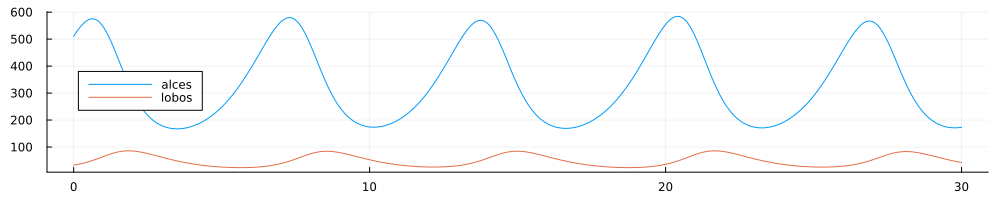

In [31]:
tt = sol.t
vv = [u[1] for u in sol.u]
ww = [u[2] for u in sol.u]

plot(tt,[vv,ww], xlabel="t",label=["alces" "lobos"], legend=:left, size=(1000,200))


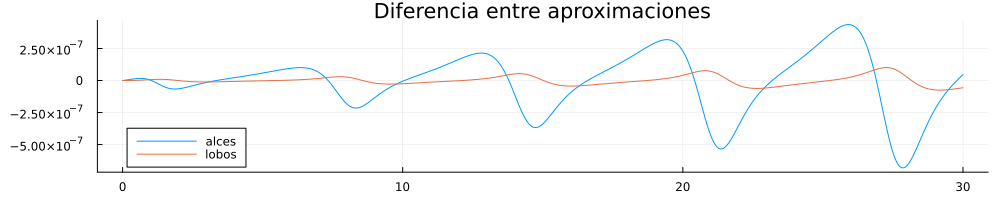

In [32]:
vv_ = [u[1] for u in sol_.u]
ww_ = [u[2] for u in sol_.u]

plot(tt,[vv-vv_,ww-ww_], title="Diferencia entre aproximaciones", xlabel="t",label=["alces" "lobos"], legend=:bottomleft, size=(1000,200))


In [33]:
U0      = BigFloat.(u0)
P       = BigFloat.(p)
Tspan   = BigFloat.(tspan)
Prob = ProblemaEDOs(f, U0, Tspan, P)

ProblemaEDOs{typeof(f), BigFloat}(Main.f, BigFloat[510.0, 33.0], (0.0, 30.0), BigFloat[1.0, 0.0200000000000000004163336342344337026588618755340576171875, 0.003000000000000000062450045135165055398829281330108642578125, 1.0])

In [34]:
n = 10000
m = 100
@time sol2  = EulerMejorado(Prob, n, m)
@time sol2_ = EulerMejorado(Prob, n, 2m);

  8.897364 seconds (107.50 M allocations: 4.591 GiB, 5.75% gc time, 0.63% compilation time)
 17.531879 seconds (214.97 M allocations: 9.180 GiB, 5.22% gc time)


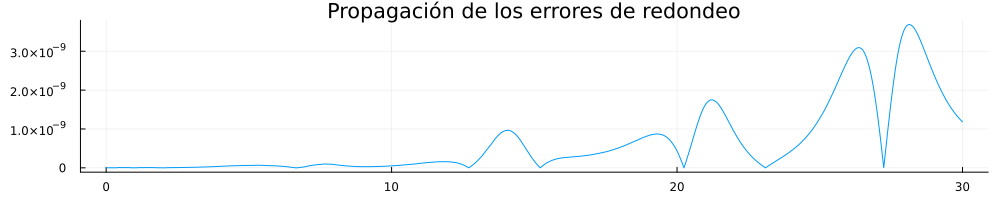

TypeError: TypeError: in typeassert, expected REPL.REPLCompletions.MethodCompletion, got a value of type REPL.REPLCompletions.TextCompletion

In [35]:
TT = sol2.t
VV = [u[1] for u in sol2.u]
WW = [u[2] for u in sol2.u]

# errores = sqrt.((vv - VV).^2 + (vv - VV).^2) # Operaciones coponente a componente
errores = @. sqrt((vv - VV)^2 + (vv - VV)^2) # Equivalente. @. dice que interprete todo lo de la derecha comopnente a componente

plot(tt, errores, title= "Propagación de los errores de redondeo", xlabel="t",label="log10(errores)", legend=false, size=(1000,200))

#### 3 - Implementación alternativa del método de Euler Mejorado

In [36]:
function f!(du, t,u,p)
    # du es input/input
    v = u[1]
    w = u[2]
    a = p[1]
    b = p[2]
    c = p[3]
    
    d  = p[4]
    gt = 1/20 * (sin(π*t/12))^2
    # return [(a-b*w - gt) * v, (c*v-d) * w]
    
    du[1] = (a-b*w - gt) * v
    du[2] = (c*v-d) * w
    return nothing
end

f! (generic function with 1 method)

In [49]:
function  EulerMejoradov1(problema::ProblemaEDOs{ftype,fltype},n::Integer,m::Integer=1) where {ftype<:Function,fltype<:AbstractFloat}
    # n: número de soluciones/vectores de estado a calcular
    # m: cada cuántos steps se guarda un vector de estado para el cálculo final
    # En funcion de n y m se calcula h -> 
    #      h: Intervalo de tiempo entre cada una de las soluciones guardadas (si m = 1).
    #         Si no, el intervalo de tiempo entre cada una de las soluciones es h * m
    
    u0   = problema.u0    # Vector de la solución inicial
    t0,T = problema.tspan # Intervalo de tiempo para calcular la solución aproximada
    p    = problema.p     # Vector de parámetros constantes
    f!   = problema.f     # Función de modelado del problema | Ecuación diferencial a resolver (en formato vectorial)
    
    h = (T-t0)/(n*m) # Intervalo de tiempo entre cada una de las soluciones
    tt = [t0]        # Vector de tiempos
    uu = [u0]        # Vector de estados
    
    tj   = copy(t0)     # Inicializar el instante inicial
    uj   = copy(u0)     # Inicializar el vector de estado inicial
    uj_  = similar(u0)  # Inicializar como un vector vacío similar a u0
    duj  = similar(u0)  # Inicializar como un vector vacío similar a u0
    duj_ = similar(u0)  # Inicializar como un vector vacío similar a u0
    
    for j in 1:n
        # Para cada solución que queremos guardar
        for i in 1:m    
            # Avanzamos m steps en el método de Euler Mejorado
            # *1: Realizar las operaciones componente a componente para evitar crear nuevos vectores
            
            f!(duj, tj, uj, p)
            @. uj_ = uj + h * duj # *1 
            tj_ = tj + h
            f!(duj_, tj_, uj_, p)
            @. uj = uj + h/2 * (duj + duj_) # *1
            tj = tj_
        
        end
        # Guardamos t y u
        push!( tt, copy( tj ) )
        push!( uu, copy( uj ) )
    end
    
    return SolucionProblemaEDOs(tt,uu,problema)
end

EulerMejoradov1 (generic function with 2 methods)

In [40]:
u0 = [510., 33.]
p = [1.,1/50,3/1000,1.]
tspan = (0.,30.)

prob  = ProblemaEDOs(f, u0, tspan, p)
prob! = ProblemaEDOs(f!, u0, tspan, p);

In [50]:
n = 10000
m = 100
@time sol   = EulerMejorado(prob, n, m)
@time sol!  = EulerMejoradov1(prob!, n, m);
@time sol!  = EulerMejoradov1(prob!, n, m);
@time sol2! = EulerMejoradov1(prob!, n, 2m); # Ya no hay garbage collection :D!!

  0.190988 seconds (14.00 M allocations: 534.695 MiB, 28.63% gc time)
  0.115656 seconds (233.89 k allocations: 12.823 MiB, 77.84% compilation time)
  0.025595 seconds (20.04 k allocations: 1.401 MiB)
  0.050839 seconds (20.04 k allocations: 1.401 MiB)


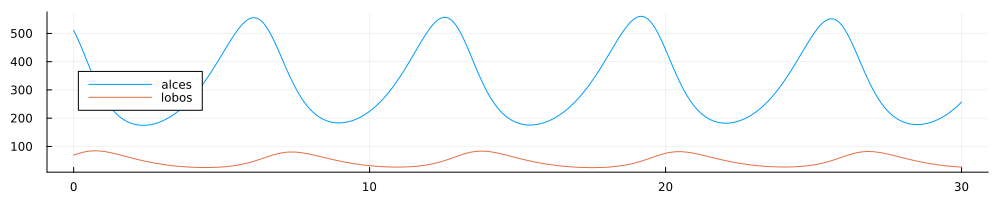

In [51]:
tt! = sol!.t
vv! = [u[1] for u in sol!.u]
ww! = [u[2] for u in sol!.u]

plot(tt!,[vv!,ww!], xlabel="t",label=["alces" "lobos"], legend=:left, size=(1000,200))